<a href="https://colab.research.google.com/github/klsharma22/TensorflowCertifcationCourse/blob/main/Transfer%20Learning/06_Transfer_Learning_in_Tensorflow_Part_3_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading necessary files

In [1]:
import os

In [2]:
#Download the helper function
if not os.path.exists('/content/helper_functions.py'):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-23 13:57:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-23 13:57:42 (73.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## IMporting all the depndencies

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from helper_functions import unzip_data, make_confusion_matrix, walk_through_dir, plot_loss_curves, compare_historys
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import os

In [4]:
if not os.path.exists('/content/101_food_classes_10_percent.zip'):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
    unzip_data('101_food_classes_10_percent.zip')

--2024-02-23 13:57:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  18.1MB/s    in 88s     

2024-02-23 13:59:18 (17.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



## Initialising the constants

In [5]:
TRAIN_DIR = '101_food_classes_10_percent/train/'
TEST_DIR = '101_food_classes_10_percent/test/'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
LABEL_MODE = 'categorical'

## Loading dataset

In [6]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR, label_mode= LABEL_MODE, batch_size= BATCH_SIZE, image_size= IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR, label_mode= LABEL_MODE, batch_size= BATCH_SIZE, image_size= IMG_SIZE)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Creating a data augmentation layer for preprocessing before model inference

In [7]:
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.Rescaling(1/255.)
], name= 'data_augmentation')

## Creating the model with MobileNet as base model

In [8]:
base_model = tf.keras.applications.MobileNet(include_top= False)
base_model.trainable = False

inputs = layers.Input(shape= IMG_SIZE + (3, ), name= 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training= False)
x = layers.GlobalAveragePooling2D(name= 'global_average_pooling_layer')(x)
outputs = layers.Dense(len(train_data.class_names), activation= 'softmax', name= 'output_layer')(x)

model = tf.keras.Model(inputs, outputs)

17225924/17225924 [==============================] - 2s 0us/step


In [9]:
model.compile(loss= 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(),
              metrics= ['accuracy'])

In [10]:
### Fitting the model with no fine-tuning and with 10 epochs

In [11]:
history_no_fine_tune = model.fit(train_data,
          epochs= 10,
          steps_per_epoch= len(train_data),
          validation_data= test_data,
          validation_steps= int(0.15 * len(test_data)))

Epoch 1/10
237/237 [==============================] - 124s 504ms/step - loss: 3.8877 - accuracy: 0.1522 - val_loss: 2.7653 - val_accuracy: 0.3294
Epoch 2/10
237/237 [==============================] - 87s 364ms/step - loss: 2.6711 - accuracy: 0.3486 - val_loss: 2.3593 - val_accuracy: 0.4166
Epoch 3/10
237/237 [==============================] - 73s 305ms/step - loss: 2.2858 - accuracy: 0.4335 - val_loss: 2.1754 - val_accuracy: 0.4462
Epoch 4/10
237/237 [==============================] - 60s 251ms/step - loss: 2.0606 - accuracy: 0.4804 - val_loss: 2.0909 - val_accuracy: 0.4701
Epoch 5/10
237/237 [==============================] - 59s 247ms/step - loss: 1.9092 - accuracy: 0.5192 - val_loss: 2.0578 - val_accuracy: 0.4730
Epoch 6/10
237/237 [==============================] - 53s 219ms/step - loss: 1.7483 - accuracy: 0.5483 - val_loss: 2.0496 - val_accuracy: 0.4746
Epoch 7/10
237/237 [==============================] - 53s 221ms/step - loss: 1.6512 - accuracy: 0.5756 - val_loss: 2.0080 - val_a

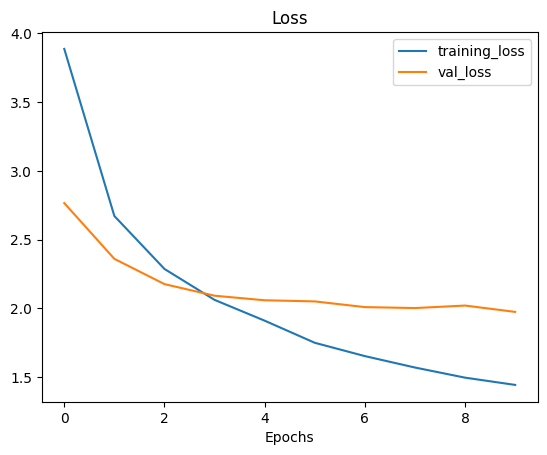

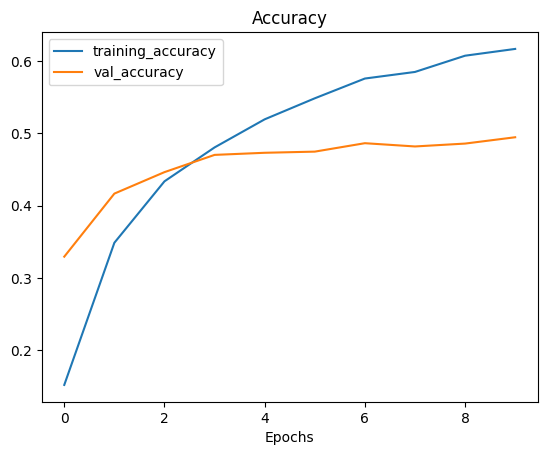

In [13]:
plot_loss_curves(history_no_fine_tune)

## Exercise 2: Fine tune the data with 5 epochs normal training and 5 epochs with fine-tuning

In [14]:
model.compile(loss= 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(),
              metrics= ['accuracy'])

In [16]:
with tf.device('/device:GPU:0'):
  history_fine_tune_1 = model.fit(train_data,
            epochs= 5,
            steps_per_epoch= len(train_data),
            validation_data= test_data,
            validation_steps= int(0.15 * len(test_data)))

Epoch 1/5
237/237 [==============================] - 42s 176ms/step - loss: 1.4150 - accuracy: 0.6268 - val_loss: 2.0639 - val_accuracy: 0.4791
Epoch 2/5
237/237 [==============================] - 43s 178ms/step - loss: 1.3204 - accuracy: 0.6418 - val_loss: 2.0685 - val_accuracy: 0.4780
Epoch 3/5
237/237 [==============================] - 43s 180ms/step - loss: 1.2897 - accuracy: 0.6482 - val_loss: 2.0925 - val_accuracy: 0.4719
Epoch 4/5
237/237 [==============================] - 39s 162ms/step - loss: 1.2332 - accuracy: 0.6628 - val_loss: 2.0019 - val_accuracy: 0.4952
Epoch 5/5
237/237 [==============================] - 43s 178ms/step - loss: 1.1958 - accuracy: 0.6688 - val_loss: 2.0606 - val_accuracy: 0.4838


In [17]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False


In [18]:
model.compile(loss= 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(),
              metrics= ['accuracy'])

In [21]:
with tf.device('/device:GPU:0'):
  history_fine_tune_2 = model.fit(train_data,
                                  epochs= 10,
                                  steps_per_epoch= len(train_data),
                                  validation_data= test_data,
                                  validation_steps= int(0.15 * len(train_data)),
                                  initial_epoch= history_fine_tune_1.epoch[-1])

Epoch 5/10
237/237 [==============================] - 39s 148ms/step - loss: 4.2971 - accuracy: 0.1869 - val_loss: 3.0195 - val_accuracy: 0.2714
Epoch 6/10
237/237 [==============================] - 35s 146ms/step - loss: 3.0463 - accuracy: 0.2758 - val_loss: 2.5978 - val_accuracy: 0.3634
Epoch 7/10
237/237 [==============================] - 30s 125ms/step - loss: 2.7549 - accuracy: 0.3320 - val_loss: 2.5461 - val_accuracy: 0.3714
Epoch 8/10
237/237 [==============================] - 29s 120ms/step - loss: 2.5844 - accuracy: 0.3661 - val_loss: 2.4867 - val_accuracy: 0.3812
Epoch 9/10
237/237 [==============================] - 28s 116ms/step - loss: 2.4011 - accuracy: 0.4042 - val_loss: 2.5014 - val_accuracy: 0.4027
Epoch 10/10
237/237 [==============================] - 29s 119ms/step - loss: 2.3020 - accuracy: 0.4203 - val_loss: 2.5216 - val_accuracy: 0.3893


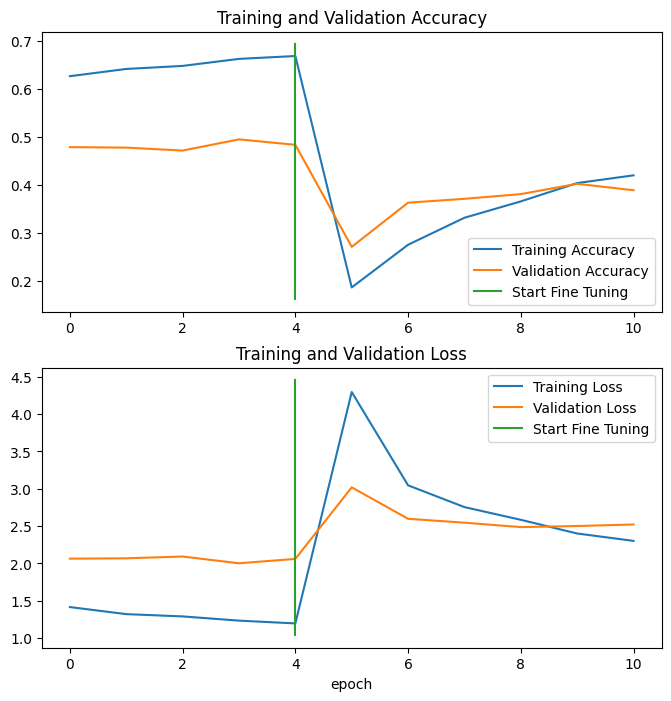

In [22]:
compare_historys(history_fine_tune_1,
                 history_fine_tune_2)